### Effect of Ancestry proportion on heritability estimation

#### simulate random mating model admixed population with different admixture proportion

### plot distribution of fst

In [15]:
import pandas as pd
filename="ref_0.2prop_updateid.fst"
fst_file=pd.read_csv(filename, sep='\t')
fst_file

,CHR,SNP,POS,NMISS,FST
0,1,1_1130_A_T,1130,2000,0.022350
1,1,1_2499_A_T,2499,2000,0.029390
2,1,1_2743_A_T,2743,2000,0.103023
3,1,1_3425_A_T,3425,2000,0.133694
4,1,1_3590_A_T,3590,2000,0.133694
...,...,...,...,...,...
244477,10,10_19993573_A_T,19993573,2000,0.034301
244478,10,10_19996444_A_T,19996444,2000,0.030665
244479,10,10_19997809_A_T,19997809,2000,0.145789
244480,10,10_19998997_A_T,19998997,2000,0.087542


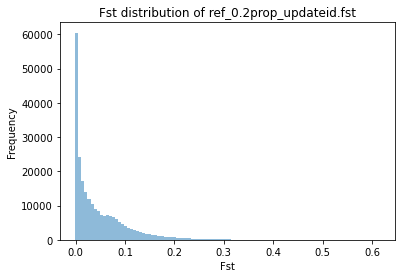

In [16]:
# plot histogram
ax = fst_file['FST'].plot.hist(bins=100, alpha=0.5, title=f'Fst distribution of {filename}')
ax.set(xlabel="Fst")
fig = ax.get_figure()
fig.savefig(f'Fst_hist_{filename}.png')

In [25]:
# how many variants has fst=0.2
fst_file[(fst_file['FST']<0.25) & (fst_file['FST']>0.15)]

#df[(df['B']<8) & (df['B']>2)]

,CHR,SNP,POS,NMISS,FST
13,1,1_7660_A_T,7660,2000,0.243736
14,1,1_7851_A_T,7851,2000,0.244441
34,1,1_30677_A_T,30677,2000,0.221929
36,1,1_32263_A_T,32263,2000,0.182123
37,1,1_32702_A_T,32702,2000,0.181623
...,...,...,...,...,...
244106,10,10_19694076_A_T,19694076,2000,0.160120
244142,10,10_19733204_A_T,19733204,2000,0.166770
244143,10,10_19734239_A_T,19734239,2000,0.212080
244169,10,10_19753140_A_T,19753140,2000,0.177897


In [12]:
# plot distribution of phenotype
import pandas as pd
filename="pheno_ADM_0.2prop_2kCausal.txt"
f=pd.read_csv(filename, sep=' ', header=None)
f

,0,1,2
0,AA,2000indv,1.315807
1,AA,2001indv,1.739441
2,AA,2002indv,-1.176716
3,AA,2003indv,-0.705395
4,AA,2004indv,1.584151
...,...,...,...
9995,AA,11995indv,0.907247
9996,AA,11996indv,0.610003
9997,AA,11997indv,1.447562
9998,AA,11998indv,1.183268


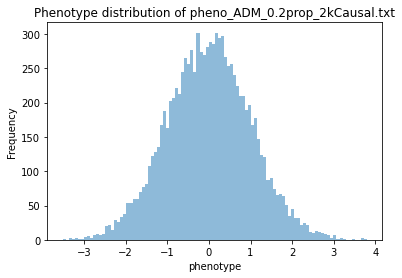

In [14]:
# plot histogram
ax = f[2].plot.hist(bins=100, alpha=0.5, title=f'Phenotype distribution of {filename}')
ax.set(xlabel="phenotype")
fig = ax.get_figure()
fig.savefig(f'Pheno_hist_{filename}.png')

### output local ancestry with smaller sample size 

In [45]:
# try to run it on a loop on a set of 100 individuals at a time in the same script
# use a psudo simple model
import tskit
import numpy as np
import msprime
pop0 = msprime.PopulationConfiguration(sample_size=20000, initial_size = 30000)
pop1 = msprime.PopulationConfiguration(sample_size=20000, initial_size = 30000)

M = np.array([
[0, 0.10],
[0.08, 0]])

ts = msprime.simulate(
        population_configurations = [pop0, pop1],
        demographic_events = [msprime.CensusEvent(time=1000)],
        migration_matrix = M,
        length = 1000,
        random_seed = 31,
        recombination_rate = 1e-7)

# replace the parent to population label
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

def local_ancestry(Tcensus, ts, filename):
    # select nodes that are Tcensus generations ago
    ancestors_Tcensus_gens = np.where(ts.tables.nodes.time == Tcensus)[0]
    # which of your samples descend from which ancestors
    #ancestrytable_Tcensus_gens = ts.tables.link_ancestors(
    #samples=ts.samples(), ancestors=ancestors_Tcensus_gens)
    ### loop on a small set 
    a_list=ts.samples()
    length = len(a_list) #total number of sample size
    lu=100 #loop unit:loop 100 at a time
    ln=length//lu +1 #loop number
    x=0  #initial number for the start index
    for i in range(1,ln):
        mysample = a_list[x:(x+lu)]
        x=lu*i #new start index
        ancestrytable_Tcensus_gens = ts.tables.link_ancestors(
        samples=mysample, ancestors=ancestors_Tcensus_gens)
        # replace the parent to population label
        #nodeTable = ts.tables.nodes
        import pandas as pd
        ancestry_table = pd.DataFrame(
            data = {
                'left': ancestrytable_Tcensus_gens.left,
                'right': ancestrytable_Tcensus_gens.right,
                'populations': [get_population_id(u, ts) for u in ancestrytable_Tcensus_gens.parent],
                'child': ancestrytable_Tcensus_gens.child
            }
        )
        #return ancestry_table
        # output the ancestry table to a file, append mode so it will accumulate for each loop
        ancestry_table.to_csv(f'loc_anc_{filename}.txt', sep='\t', encoding='utf-8', index=False, header=False, mode='a')
    
# run the function
local_ancestry(1000, ts, filename="test")



In [24]:
#select samples
#len(ts.samples()[:100])
x=0
#len(ts.samples()[x:x+100])
#ts.samples()[3000:]
ts.samples()[x:x+100]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int32)

In [17]:
# cut the ts.sample() in half
a_list=ts.samples()
length = len(a_list)
middle_index = length//2
first_half = a_list[:middle_index]
first_half

array([   0,    1,    2, ..., 1997, 1998, 1999], dtype=int32)

In [42]:
# test function to loop
a_list=ts.samples()
length = len(a_list) #total number of sample size

lu=400 #loop unit:loop 100 at a time
ln=length//lu +1#loop number
x=0
for i in range(1,ln):
    mysample = a_list[x:(x+lu)]
    x=lu*i
    print(i)
    print(mysample)

1
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 